In [2]:
import numpy as np
import pandas as pd

# Carregamento dos dados 

In [3]:
df1 = pd.read_csv("data/raw/accepted_2007_to_2018Q4.csv")
df1 = df1.drop(columns=["member_id", "url"])
df1.info(verbose=True, null_counts=True)

C:\Users\Renan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 149 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          2260701 non-null  object 
 1   loan_amnt                                   2260668 non-null  float64
 2   funded_amnt                                 2260668 non-null  float64
 3   funded_amnt_inv                             2260668 non-null  float64
 4   term                                        2260668 non-null  object 
 5   int_rate                                    2260668 non-null  float64
 6   installment                                 2260668 non-null  float64
 7   grade                                       2260668 non-null  object 
 8   sub_grade                                   2260668 non-null  object 
 9   emp_title                                   2093699 non-

# Seleção das variáveis

Não serão usadas todas as variáveis disponíveis.

Manualmente selecionamos algumas variáveis que consideramos mais relevantes.

In [4]:
features = df1.loc[:, [
    "term", # Número de pagamentos pagamentos no plano
    "annual_inc", # Renda Anual
    "annual_inc_joint", # Renda anual conjunta se o empréstimo é conjunto
    "emp_length", # Tempo no emprego
    "issue_d", # data do empréstimo, para comparar com a taxa de juros básica
    "purpose", # objetivo
    "dti", # Debt-to-income <https://www.investopedia.com/terms/d/dti.asp>
    "delinq_2yrs", # 'faltas' no pagamento nos últimos 2 anos
    "open_acc", # Número de linhas de crédito abertas no histórico do cliente
    "open_il_12m", # Número de contas de prestação abertas nos últimos 12m
    "open_rv_12m", # Número de contas de crédtio rotativo abertas nos últimos 12m
    "pub_rec", # Number of derogatory public records
    "revol_util", # Fração do crédito giratório disponível sendo usado
    "chargeoff_within_12_mths", # número de declarações de 'improvável pagar' nos últimos 12m
    "mort_acc", # número de hipotecas
    "num_accts_ever_120_pd", # número de contas que já foram atrasadas a mais de 120 dias
    "num_tl_120dpd_2m", # número de contas atualmente atrasadas mais de 120 dias(atualizadas nos últimos 2 meses)
    "num_tl_30dpd", # Número de contas atualemente atrasadas mais de 30 dias
    "percent_bc_gt_75", # fração de contas acima de 75% do limite
    ]]

features.head()

,term,annual_inc,annual_inc_joint,emp_length,issue_d,purpose,dti,delinq_2yrs,open_acc,open_il_12m,open_rv_12m,pub_rec,revol_util,chargeoff_within_12_mths,mort_acc,num_accts_ever_120_pd,num_tl_120dpd_2m,num_tl_30dpd,percent_bc_gt_75
0,36 months,55000.0,NaN,10+ years,Dec-2015,debt_consolidation,5.91,0.0,7.0,0.0,3.0,0.0,29.7,0.0,1.0,2.0,0.0,0.0,0.0
1,36 months,65000.0,NaN,10+ years,Dec-2015,small_business,16.06,1.0,22.0,0.0,2.0,0.0,19.2,0.0,4.0,0.0,0.0,0.0,7.7
2,60 months,63000.0,71000.0,10+ years,Dec-2015,home_improvement,10.78,0.0,6.0,0.0,0.0,0.0,56.2,0.0,5.0,0.0,0.0,0.0,50.0
3,60 months,110000.0,NaN,10+ years,Dec-2015,debt_consolidation,17.06,0.0,13.0,0.0,1.0,0.0,11.6,0.0,1.0,0.0,0.0,0.0,0.0
4,60 months,104433.0,NaN,3 years,Dec-2015,major_purchase,25.37,1.0,12.0,0.0,4.0,0.0,64.5,0.0,6.0,0.0,0.0,0.0,60.0


# Limpeza dos dados

Diversos dados estão em formatos não apropriados ou devem ser transformados em outras variáveis.

Por motivos de performance e legibilidade geralmente será criada uma função e usada o método apply do pandas.

## Formatando *Term*

A coluna Term veio em formato de texto, porém é mais apropriado que seja um número inteiro.

In [8]:
def formatTerm(line):
    if np.nan_to_num(line, nan=-1) == -1:
        return np.NaN

    line = line.strip()
    line = line.split(" ")

    if line[-1] == "months":
        line = int(line[0])/12

    else:
        raise NotImplementedError(f"{line[-1]} não implementado ainda")

    return line

features["term"] = features["term"].apply(formatTerm)

## Dummyficação de OWNERSHIP

A coluna OWNERSHIP será transformada em dummies.

O valor OWN será descartado para evitar multicolinearidade perfeita.

In [10]:
features = features.join(pd.get_dummies(df1["home_ownership"]))
features = features.drop(columns="OWN")

ownership = ["ANY", "MORTGAGE", "NONE", "OTHER", "RENT"]

## Adaptação de *EmpLength*

Da coluna *EmpLength* queremos saber apenas se o indivíduo está no trabalho a mais de um ano.

In [11]:
def formatEmpLength(line):
    """ Testa se o indivíduo está a mais de dois anos no trabalho atual """
    Accept = ["3 years", "2 years", "8 years", "10+ years", "4 years", "6 years", "5 years", "9 years", "7 years"]
    NotAccept = ["1 year", "< 1 year", np.nan]

    if line in Accept:
        return 1
    elif line in NotAccept:
        return 0
    else:
        raise NotImplementedError(f"{line} não implementado ainda na função cleanEmpLength")

features["emp_length"] = features["emp_length"].apply(formatEmpLength)
features = features.rename(columns={"emp_length": "long_job"})

## Dummyficação de *purpose*

A coluna será transformada em três outras variáveis:

1. GoodPurpose: se o uso original é: 'small_business', 'renewable_energy', 'home_improvement', 'major_purchase', 'moving', 'house', 'car' ou 'educational'

2. BadPurpose: se o uso original é: 'debt_consolidation', 'credit_card' ou 'medical'

3. NeutralPurpose: se o uso original é: 'other', 'vacation' ou 'wedding'

In [15]:
def toIntPurpose(line):
    goodList = ["small_business", "renewable_energy", "home_improvement", "major_purchase", "moving", "house", "car", "educational"]
    badList = ["debt_consolidation", "credit_card", "medical"]
    neutralList = ["other", "vacation", "wedding", np.nan]

    if line in goodList:
        return 1

    elif line in badList:
        return -1

    elif line in neutralList:
        return 0

    else:
        raise NotImplementedError(f"Purpose {line} não está em nenhuma categoria")

features = features.join(
    pd.get_dummies(
    features["purpose"]
    .apply(toIntPurpose))
    .rename(columns={
        -1: "BadPurpose",
        0: "NeutralPurpose",
        1: "GoodPurpose"
        })
    )

features = features.drop(columns="purpose")

KeyError: 'purpose'

## Formatação de *JointIncome*

In [16]:
def formatJointIncome(line):
    if np.nan_to_num(line) == 0:
        return 0
    
    else:
        return float(line)

features["annual_inc_joint"] = features["annual_inc_joint"].apply(formatJointIncome).apply(np.nan_to_num)

## Formatação da data da operação

Além da formatação da data serão incluidos dados sobre a taxa de juros corrente e a inflação(CPI) dos últimos doze meses.

In [17]:
from utils.getCPI import getCPI
from utils.getIntRate import getIntRate

cpi = getCPI()
intRate = getIntRate()

extInf = pd.merge(left=cpi, right=intRate, left_on="date", right_on="date")
features["issue_d"] = pd.to_datetime(features["issue_d"])
features = pd.merge(left=features, right=extInf, left_on="issue_d", right_on="date")
features = features.drop(columns=["date", "issue_d"])

## Formatação de *delinq_2yrs*

A coluna representa o número de 'faltas' nos pagamentos dos últimos dois anos e será transformada em uma variável binária.

A coluna assumirá o valor de:

- 0, se seu valor original for 0
- 1, caso contrário


In [19]:
def formatDelinq(line):
    if line == 0:
        return 0

    elif line >= 0:
        return 1
    
    if np.nan_to_num(line) == 0:
        return 0

    else:
        raise NotImplementedError(f"Valor inválido: {line}")

features["delinq_2yrs"] = features["delinq_2yrs"].apply(formatDelinq)
features = features.rename(columns={"delinq_2yrs": "delinq"})

## Formatação de *open_acc*, *open_il_12m*, *open_rv_12m* e *mort_acc*

A coluna *open_acc* será transformada na coluna *recent* de acordo com a seguinte regra:
    1, se igual 1 ou 2
    0, caso contrário

Essa transformação deve capturar se o cliente é novo ou antigo.

As colunas *open_il_12m*, *open_rv_12m* e *mort_acc* serão somadas se o valor for maior que 2, o cliente receberá a dummy *multiplasContas*.

In [22]:
def formatOpenAcc(line):
    if line in [0, 1, 2]:
        return 1

    elif line > 2:
        return 0
    
    if np.nan_to_num(line) == 0:
        return 0
    
    else:
        raise NotImplementedError(f"Valor inválido para OpenAcc: {line}")

features["recent"] = features["open_acc"].apply(formatOpenAcc)
features = features.drop(columns="open_acc")

def formatSecondOpenAcc(line):
    if line >= 2:
        return 1
    
    elif line >= 0 and line < 2:
        return 0
    
    elif np.nan_to_num(line, nan=-1) == -1:
        return np.NaN

    else:
        raise NotImplementedError(f"Número de contas abertas inválidas, valor que causou o erro: {line}")

openAcc = features["open_il_12m"] + features["open_rv_12m"] + features["mort_acc"]
features["multiplasContas"] = openAcc.apply(formatSecondOpenAcc)
features = features.drop(columns=["open_il_12m", "open_rv_12m", "mort_acc"])

## Formatação de *pub_rec*

Se o valor for maior que zero, o indivíduo receberá a dummy *bad_rec*

In [25]:
def formatPubRec(line):
    if line >= 1:
        return 1
    
    elif line == 0:
        return 0
    
    if np.nan_to_num(line) == 0:
        return 0

    else:
        raise NotImplementedError(f"Entrada inválida em PubRec, valor que causou o erro: {line}")

features["bad_rec"] = features["pub_rec"].apply(formatPubRec)
features = features.drop(columns="pub_rec")

KeyError: 'pub_rec'

## Formatação de *revol_util* e *percent_bc_gt_75*

Se o indivíduo tem *revol_util* maior que 30% ou *percent_bc_gt_75* = 1, o indivíduo receberá a dummy *almostBroken
*

In [26]:
def formatRevolUtil(line):
    if line >= 30:
        return 1

    elif line < 30:
        return 0

    elif np.nan_to_num(line, nan=-1) == -1:
        return np.NaN

    else:
        raise NotImplementedError(f"Entrada inválida em revol_util, valor que causou o erro: {line}")

features["badRevolUtil"] = features["revol_util"].apply(formatRevolUtil)

def almostBadCard(line):
    if line > 0:
        return 1
    
    elif line == 0:
        return 0
    
    elif np.nan_to_num(line, nan=-1) == -1:
        return np.NaN

    else:
        raise ValueError(f"valor inválido na coluna percent_bc_gt_75, valor que causou o erro: {line}")

features["percent_bc_gt_75"] = features["percent_bc_gt_75"].apply(almostBadCard)

almostBroke = features["percent_bc_gt_75"] + features["badRevolUtil"]

def formatAlmostBroke(line):
    if line >= 1:
        return 1

    elif line == 0:
        return 0

    elif np.nan_to_num(line, nan=-1) == -1:
        return np.NaN

    else:
        raise NotImplementedError(f"Entrada inválida em almostBroke, valor que causou o erro: {line}")

features = features.drop(columns=["revol_util", "percent_bc_gt_75", "badRevolUtil"])

features["almostBroken"] = almostBroke.apply(formatAlmostBroke)

## Formatação de *chargeoff_within_12_mths*

Se o indivíduo tiver valor diferente de 0 nessa variável, ele receberá a dummy *chargeOff*

In [28]:
def formatChargeOff(line):
    if line > 0:
        return 1
    
    elif line == 0:
        return 0
    
    elif np.nan_to_num(line, nan=-1) == -1:
        return np.NaN

    else:
        raise NotImplementedError(f"Entrada inválida em chargeoff_within_12_mths, valor que causou o erro: {line}")

features["chargeOff"] = features["chargeoff_within_12_mths"].apply(formatChargeOff)
features = features.drop(columns="chargeoff_within_12_mths")

## Formatação de *num_accts_ever_120_pd*, *num_tl_120dpd_2m* e *num_tl_30dpd*

Os valores dessas colunas serão somados e se maiores que 1 o indivíduo receberá a dummy *overDue*, que captará se o indivíduo tem histórico de atrasar contas.

In [29]:
overDue = features["num_accts_ever_120_pd"] + features["num_tl_120dpd_2m"] + features["num_tl_30dpd"]
features = features.drop(columns=["num_accts_ever_120_pd", "num_tl_120dpd_2m", "num_tl_30dpd"])

def formatOverDue(line):
    if line > 0:
        return 1
    
    elif line == 0:
        return 0
    
    elif np.nan_to_num(line, nan=-1) == -1:
        return np.NaN

    else:
        raise ValueError(f"Entrada inválida em uma das seguintes colunas = [num_accts_ever_120_pd, num_tl_120dpd_2m, num_tl_30dpd], \
            Valor que causou o erro: {line}")

features["overDue"] = overDue.apply(formatOverDue)

In [30]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2260668 entries, 0 to 2260667
Data columns (total 22 columns):
 #   Column            Dtype  
---  ------            -----  
 0   term              float64
 1   annual_inc        float64
 2   annual_inc_joint  float64
 3   long_job          int64  
 4   dti               float64
 5   delinq            int64  
 6   ANY               uint8  
 7   MORTGAGE          uint8  
 8   NONE              uint8  
 9   OTHER             uint8  
 10  RENT              uint8  
 11  BadPurpose        uint8  
 12  NeutralPurpose    uint8  
 13  GoodPurpose       uint8  
 14  cpi               float64
 15  BasicIntRate      float64
 16  recent            int64  
 17  multiplasContas   float64
 18  bad_rec           int64  
 19  almostBroken      float64
 20  chargeOff         float64
 21  overDue           float64
dtypes: float64(10), int64(4), uint8(8)
memory usage: 276.0 MB


## Formatação das variáveis alvo

In [31]:
target = df1.loc[:, ["int_rate", "grade", "loan_status"]]
target.head()

,int_rate,grade,loan_status
0,13.99,C,Fully Paid
1,11.99,C,Fully Paid
2,10.78,B,Fully Paid
3,14.85,C,Current
4,22.45,F,Fully Paid


In [32]:
maskGradeToNum = {
    "A": 1,
    "B": 2,
    "C": 3,
    "D": 4,
    "E": 5,
    "G": 6,
}

target["grade"] = target["grade"].map(maskGradeToNum)

In [33]:
maskLoanStatus = {
    "Late (31-120 days)": 1,
    "Late (16-30 days)": 1,
    "Charged Off": -1,
    "Does not meet the credit policy. Status:Charged Off": -1,
    "Fully Paid": 0,
    "Does not meet the credit policy. Status:Fully Paid": 0,
    "Current": 2,
    "In Grace Period": 2
}

target["loan_status"] = target["loan_status"].map(maskLoanStatus)

In [34]:
tarDummy = pd.get_dummies(target["loan_status"])
tarDummy = tarDummy.rename(
    columns={
        -1: "chargedOff",
        0: "paid",
        1: "late",
        2: "current"
    })

target = target.join(tarDummy)
target = target.drop(columns="loan_status")

target["prob"] = target["chargedOff"] + target["late"]
target.head()

,int_rate,grade,chargedOff,paid,late,current,prob
0,13.99,3.0,0,1,0,0,0
1,11.99,3.0,0,1,0,0,0
2,10.78,2.0,0,1,0,0,0
3,14.85,3.0,0,0,0,1,0
4,22.45,NaN,0,1,0,0,0


Portanto, as variáveis alvo serão:

1. *int_rate*: taxa de juros usada no crédito;
2. *grade*: nota de risco do crédito;
3. *chargedOff*, *paid*, *late*, *current*: estado do crédito;
4. *prob*: se o cliente atrasou ou não pagou o empréstimo

In [35]:
df = target.join(features)

# Limpeza Final dos Dados

Agora serão retirados os dados que apresentam alta correlação entre si, já que esses basicamente carregam as mesmas informações

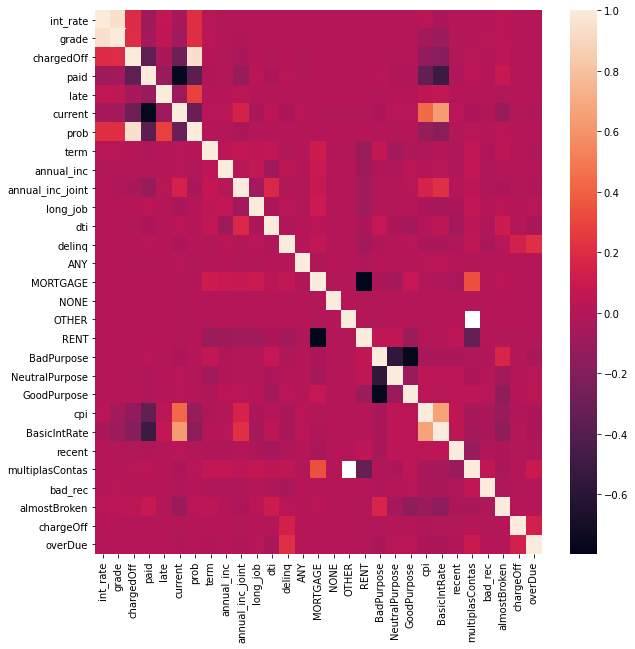

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(df.corr())
plt.show()

Como as variáveis *multiplasContas* apresenta alta correlação com *None* e *Other*. Esta será excluída.

*cpi* apresenta alta correlação com *BasicIntRate*. Portanto, também será retirada.

Como as variáveis *BadPurpose*, *NeutralPurpose* e *GoodPurpose* são mutuamente excludentes então *NeutralPurpose* será excluída

In [37]:
df = df.drop(columns=["multiplasContas", "cpi", "NeutralPurpose"])